# Week 6_Day 4: Improving CIFAR-10 CNN

### Dataset, Transforms and Dataloader(for improved CNN)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

# Transform: turn image into tensor
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load full training set
full_train_aug = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

full_train_clean = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_test
)

# Split into train/val
train_size = int(0.9 * len(full_train_aug))
val_size = len(full_train_aug) - train_size

train_split, val_split = random_split(full_train_aug, [train_size, val_size])

train_ds = Subset(full_train_aug, train_split.indices)
val_ds   = Subset(full_train_clean, val_split.indices)

# Test set (separate)
test_ds = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

### Setup: Model, Loss, Optimizer, Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # conv layer1
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=32,
            kernel_size=3, 
            padding=1
        )
        # batch normalization 1
        self.bn1   = nn.BatchNorm2d(32)

        # conv layer2
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        # batch normalization 2
        self.bn2   = nn.BatchNorm2d(64)

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fc layers
        self.fc1 = nn.Linear(64*8*8, 256)
        self.dropout = nn.Dropout(0.1)  # dropout
        self.fc2 = nn.Linear(256, 10)

    def forward(self,x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [4]:
model = SimpleCNN().to(device)

In [5]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

### Training Loop

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # enables training behavior 

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [7]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # disables training behavior

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### Run Training for Multiple Epochs + Track Curves

In [8]:
import matplotlib.pyplot as plt

EPOCHS = 30

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

Epoch 1/30 | Train Loss: 1.8461, Train Acc: 0.3426 | Val Loss: 1.4411, Val Acc: 0.4770
Epoch 2/30 | Train Loss: 1.4659, Train Acc: 0.4581 | Val Loss: 1.2524, Val Acc: 0.5580
Epoch 3/30 | Train Loss: 1.3232, Train Acc: 0.5168 | Val Loss: 1.0787, Val Acc: 0.6254
Epoch 4/30 | Train Loss: 1.2448, Train Acc: 0.5476 | Val Loss: 0.9977, Val Acc: 0.6420
Epoch 5/30 | Train Loss: 1.1959, Train Acc: 0.5672 | Val Loss: 1.0003, Val Acc: 0.6484
Epoch 6/30 | Train Loss: 1.1566, Train Acc: 0.5854 | Val Loss: 0.9490, Val Acc: 0.6614
Epoch 7/30 | Train Loss: 1.1163, Train Acc: 0.5977 | Val Loss: 0.8914, Val Acc: 0.6864
Epoch 8/30 | Train Loss: 1.0770, Train Acc: 0.6160 | Val Loss: 0.8836, Val Acc: 0.6930
Epoch 9/30 | Train Loss: 1.0635, Train Acc: 0.6212 | Val Loss: 0.8741, Val Acc: 0.6950
Epoch 10/30 | Train Loss: 1.0462, Train Acc: 0.6302 | Val Loss: 0.8583, Val Acc: 0.7020
Epoch 11/30 | Train Loss: 1.0158, Train Acc: 0.6432 | Val Loss: 0.8340, Val Acc: 0.7042
Epoch 12/30 | Train Loss: 0.9989, Train A

### Plot Training Curves

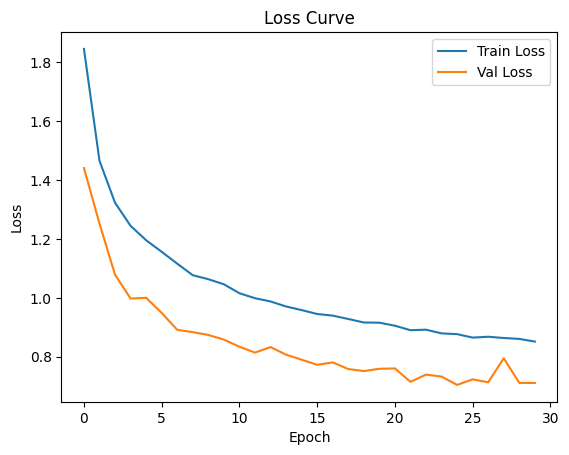

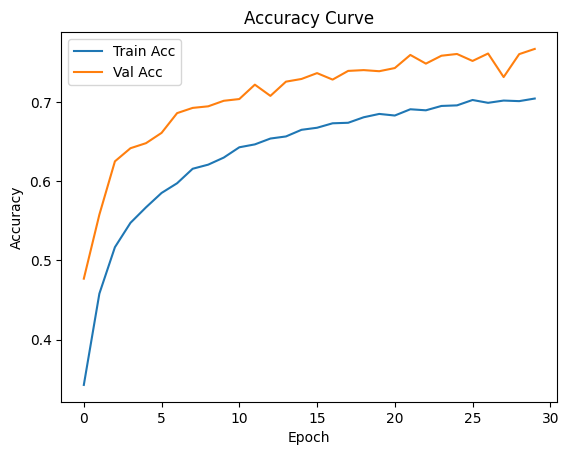

In [9]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()